In [1]:
import bqplot
import datetime
import time
import ee
from IPython.display import display, IFrame, Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from helper_functions import *
from skimage.viewer import ImageViewer
from skimage.io import imread
from imageio import imwrite
# Configure the pretty printing output.
import pprint
from tqdm import tqdm
from tqdm import tnrange
import numba as nb
#from fancyimpute import KNN, SoftImpute
from sklearn.preprocessing import normalize, StandardScaler
import pylab
from scipy.stats import normaltest, shapiro, anderson, skew
import seaborn as sns
import random
from os import listdir
from os.path import isfile, join
from matplotlib import gridspec
import statsmodels.api as sm
from skimage.io import imread
import glob
from scipy.stats import normaltest

pp = pprint.PrettyPrinter(depth=4)
tqdm.monitor_interval = 0

# Authenticate to the Earth Engine servers.
ee.Initialize()


SMALL_SIZE = 11
MEDIUM_SIZE = 15
BIGGER_SIZE = 12

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

D:\Programs\Anaconda3\lib\site-packages\skimage\viewer\utils\core.py:10: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  warn("Recommended matplotlib backend is `Agg` for full "
D:\Programs\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Inspecting Ground Truth Data Queried from USDA

In [2]:
# Importing and separating just for grains

corn_yield = pd.read_csv('data/Corn_2007-2016_ALLSTATES.csv')
corn_grain = corn_yield[(corn_yield['YIELD in BU / ACRE'] != ' ') & \
                        (corn_yield['COMMODITY'] == 'CORN, GRAIN')][['YEAR', 'LOCATION', 'STATE ANSI', 'COUNTY ANSI', 'YIELD in BU / ACRE', 'AREA HARVESTED in ACRES']] \
             .rename(columns={'STATE ANSI':'STATE_FIPS', 'COUNTY ANSI':'COUNTY_FIPS', 'YIELD in BU / ACRE':'YIELD', 'AREA HARVESTED in ACRES':'AREA'})
corn_silage = corn_yield[(corn_yield['YIELD in TONS / ACRE'] != ' ') & (corn_yield['COMMODITY'] == 'CORN, SILAGE')]

# Drop those that combined counties/ and no areas of planting and make sure it's int
corn_grain = corn_grain[corn_grain['COUNTY_FIPS'] != '   ']
corn_grain = corn_grain[corn_grain['AREA'] != ' '].reset_index().drop(['index'], axis=1)
corn_grain['COUNTY_FIPS'] = corn_grain['COUNTY_FIPS'].map(int)
corn_grain['AREA'] = corn_grain['AREA'].apply(lambda a: int(a.replace(',', '')))
corn_grain['YIELD'] = corn_grain['YIELD'].map(float)

unique_data = sorted([list(x) for x in set(tuple(x) for x in corn_grain[['STATE_FIPS', 'COUNTY_FIPS']].values)])
fips_data = [location for location in unique_data if location not in [[46, 102], [51, 131]]] #51, 131 = All nan, 46, 102 = no results
len(fips_data)

print('There are a total of {} states with {} counties in the dataset.'.format(len(corn_grain['STATE_FIPS'].unique()), len(unique_data)))
# Print
display(corn_grain.head())
corn_grain.to_csv('data/corn_grain.csv')

There are a total of 41 states with 2106 counties in the dataset.


,YEAR,LOCATION,STATE_FIPS,COUNTY_FIPS,YIELD,AREA
0,2016,"ALABAMA, BLACK BELT, DALLAS",1,47,118.8,5000
1,2016,"ALABAMA, BLACK BELT, ELMORE",1,51,151.8,3300
2,2016,"ALABAMA, BLACK BELT, MACON",1,87,131.9,1350
3,2016,"ALABAMA, BLACK BELT, MARENGO",1,91,137.2,7800
4,2016,"ALABAMA, BLACK BELT, PERRY",1,105,123.7,5900


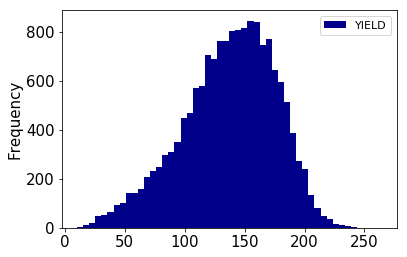

NormaltestResult(statistic=array([492.46512721]), pvalue=array([1.15493186e-107]))

In [3]:
# Corn yields distribution across U.S.

corn_grain[['YIELD']].plot.hist(bins=50, color='darkblue')
plt.savefig('yields distribution', dpi=500)
plt.show()
normaltest(corn_grain[['YIELD']].values.tolist())

In [4]:
# Getting county level information and statistics
# Note that the function is designed for more than one pic --> becareful with USDA which only give 1 pic per year

target_sat = {'USDA/NASS/CDL':['cropland'], \
              'MODIS/006/MYD11A2':[0,4], \
              'MODIS/006/MOD09A1':[0,1,2,3,4,5,6] \
        }  
folders = ['USDA_CROP', \
           'MODIS_TEMP', \
           'MODIS_LAND'
           ]
locations = [(loc[0], loc[1]) for loc in unique_data]
dates = ['2007-1-2', '2017-1-2']
scale  = 500   # 500m = 1 pixel
dates_of_images = {folder:[] for folder in folders}

#################################################################################################

county_region = ee.FeatureCollection('ft:1S4EB6319wWW2sWQDPhDvmSBIVrD3iEmCLYB7nMM')

for folder, target in zip(folders, target_sat):

    if folder == 'USDA_CROP':
        img_collection = ee.ImageCollection(target)\
                        .filterDate(dates[0], dates[1]) \
                        .select(target_sat[target]) 
    else:
        img_collection = ee.ImageCollection(target)\
                        .filterDate(dates[0], dates[1]) \
                        .select(target_sat[target]) \
                        .filter(ee.Filter.calendarRange(3,12,'month'))

    # append bands to each image when collected
    img = img_collection.iterate(appendBand)
    if folder == 'USDA_CROP':
        img = ee.Image(img).eq(1)  # only corn 
    else:
        img = ee.Image(img)

    # print basic info (bands and no. of available images)
    dates_of_images[folder] += dates_available(img_collection)
    print('\n ######################### ' + target +  ' #########################')
    print("Total Dates Available: ", len(dates_of_images[folder]))
    print("Dates available: ", dates_of_images[folder])

    collection_bands = available_bands(img_collection)
    for k, v in collection_bands.items():
        print("Band", k, "will be downloaded in", v['number_available'], "images per county. (", v['percent_available'], "%)")
        
"""
    # Getting images
    for i, (loc1, loc2) in enumerate(locations):

        im_name = folder + '_{:.0f}_{:.0f}'.format(loc1, loc2)
        scale  = scale
        crs = 'EPSG:4326'   # Coordinate Reference System

        # filter for a county
        region = county_region.filterMetadata('StateFips', 'equals', int(loc1))
        region = ee.FeatureCollection(region).filterMetadata('CntyFips', 'equals', int(loc2))
        region = ee.Feature(region.first()) # get the coordinates and other features

        while True:
            try:
                export_image(img.clip(region), folder, im_name, scale, crs)
            except Exception:
                print(Exception)
                time.sleep(10)
                continue
            break
        if (i%250 == 0) or (i == len(locations)-1):
            print(i)
"""


 ######################### USDA/NASS/CDL #########################
Total Dates Available:  10
Dates available:  ['2007-12-31', '2008-12-31', '2009-12-31', '2010-12-31', '2011-12-31', '2012-12-31', '2013-12-31', '2014-12-31', '2015-12-31', '2016-12-31']
Band cropland will be downloaded in 10 images per county. ( 100.0 %)

 ######################### MODIS/006/MYD11A2 #########################
Total Dates Available:  380
Dates available:  ['2007-03-05', '2007-03-13', '2007-03-21', '2007-03-29', '2007-04-06', '2007-04-14', '2007-04-22', '2007-04-30', '2007-05-08', '2007-05-16', '2007-05-24', '2007-06-01', '2007-06-09', '2007-06-17', '2007-06-25', '2007-07-03', '2007-07-11', '2007-07-19', '2007-07-27', '2007-08-04', '2007-08-12', '2007-08-20', '2007-08-28', '2007-09-05', '2007-09-13', '2007-09-21', '2007-09-29', '2007-10-07', '2007-10-15', '2007-10-23', '2007-10-31', '2007-11-08', '2007-11-16', '2007-11-24', '2007-12-02', '2007-12-10', '2007-12-18', '2007-12-26', '2008-03-04', '2008-03-12'

"\n    # Getting images\n    for i, (loc1, loc2) in enumerate(locations):\n\n        im_name = folder + '_{:.0f}_{:.0f}'.format(loc1, loc2)\n        scale  = scale\n        crs = 'EPSG:4326'   # Coordinate Reference System\n\n        # filter for a county\n        region = county_region.filterMetadata('StateFips', 'equals', int(loc1))\n        region = ee.FeatureCollection(region).filterMetadata('CntyFips', 'equals', int(loc2))\n        region = ee.Feature(region.first()) # get the coordinates and other features\n\n        while True:\n            try:\n                export_image(img.clip(region), folder, im_name, scale, crs)\n            except Exception:\n                print(Exception)\n                time.sleep(10)\n                continue\n            break\n        if (i%250 == 0) or (i == len(locations)-1):\n            print(i)\n"

In [5]:
# For moisture content because the collection time is not the same as MODIS, we created a time interval (+-4 days) of the MODIS image and take median out of that
# to be incorporated with MODIS.

# creating time intervals
backward = datetime.timedelta(days=-4)
date_list = [datetime.date(int(date.split('-')[0]), int(date.split('-')[1]), int(date.split('-')[2])) + backward for date in dates_of_images['MODIS_LAND']] 
date_list += [date_list[-1] - backward]

# changing to list and string format
date_list = ['{}-{}-{}'.format(date.year, date.month, date.day) for date in date_list]
date_list = [[date_list[i], date_list[i+1]] for i in range(len(date_list)-1)]

folder = 'USDA_MOISTURE'
#dates_of_images[folder] = date_list
locations = [(loc[0], loc[1]) for loc in unique_data]
scale  = 500   # 500m = 1 pixel

#################################################################################################

county_region = ee.FeatureCollection('ft:1S4EB6319wWW2sWQDPhDvmSBIVrD3iEmCLYB7nMM')
print('Total Dates {}'.format(len(date_list)))
for i, dates in enumerate(date_list):
    
    if i == 0:
        img = ee.ImageCollection('NASA_USDA/HSL/soil_moisture')\
                        .filterDate(dates[0], dates[1]) \
                        .select([0, 1]) \
                        .filter(ee.Filter.calendarRange(3,12,'month'))\
                        .median()
    else:
        img2 = ee.ImageCollection('NASA_USDA/HSL/soil_moisture')\
                    .filterDate(dates[0], dates[1]) \
                    .select([0, 1]) \
                    .filter(ee.Filter.calendarRange(3,12,'month'))\
                    .median()
        img = img.addBands(img2)
        
print('There are {} total number of images'.format(len(img.bandNames().getInfo())))
"""
# Getting images
for i, (loc1, loc2) in enumerate(locations):

    im_name = folder + '_{:.0f}_{:.0f}'.format(loc1, loc2)
    scale  = scale
    crs = 'EPSG:4326'   # Coordinate Reference System

    # filter for a county
    region = county_region.filterMetadata('StateFips', 'equals', int(loc1))
    region = ee.FeatureCollection(region).filterMetadata('CntyFips', 'equals', int(loc2))
    region = ee.Feature(region.first()) # get the coordinates and other features

    while True:
        try:
            export_image(img.clip(region), folder, im_name, scale, crs)
        except Exception:
            print(Exception)
            time.sleep(10)
            continue
        break
    if (i%500 == 0) or (i == len(locations)-1):
        print(i)
"""

Total Dates 380
There are 532 total number of images


"\n# Getting images\nfor i, (loc1, loc2) in enumerate(locations):\n\n    im_name = folder + '_{:.0f}_{:.0f}'.format(loc1, loc2)\n    scale  = scale\n    crs = 'EPSG:4326'   # Coordinate Reference System\n\n    # filter for a county\n    region = county_region.filterMetadata('StateFips', 'equals', int(loc1))\n    region = ee.FeatureCollection(region).filterMetadata('CntyFips', 'equals', int(loc2))\n    region = ee.Feature(region.first()) # get the coordinates and other features\n\n    while True:\n        try:\n            export_image(img.clip(region), folder, im_name, scale, crs)\n        except Exception:\n            print(Exception)\n            time.sleep(10)\n            continue\n        break\n    if (i%500 == 0) or (i == len(locations)-1):\n        print(i)\n"

In [6]:
# Check number of files

from os import listdir
from os.path import isfile, join

USDA_CROP_path = 'data/USDA_CROP/'
USDA_MOISTURE_path = 'data/USDA_MOISTURE/'
MODIS_TEMP_path = 'data/MODIS_TEMP/'
MODIS_LAND_path = 'data/MODIS_LAND/'

folder_list = [USDA_CROP_path, USDA_MOISTURE_path, MODIS_TEMP_path, MODIS_LAND_path]

USDA_CROP = [f for f in listdir(USDA_CROP_path) if isfile(join(USDA_CROP_path, f))]
USDA_MOISTURE = [f for f in listdir(USDA_MOISTURE_path) if isfile(join(USDA_MOISTURE_path, f))]
MODIS_TEMP = [f for f in listdir(MODIS_TEMP_path) if isfile(join(MODIS_TEMP_path, f))]
MODIS_LAND = [f for f in listdir(MODIS_LAND_path) if isfile(join(MODIS_LAND_path, f))]

MODIS_TEMP_fips = sorted([file[11:-4] for file in MODIS_TEMP if file[0:10] == 'MODIS_TEMP'])
USDA_CROP_fips = sorted([file[11:-4] for file in USDA_CROP if file[0:9] == 'USDA_MOISTURE'])
USDA_MOISTURE_fips = sorted([file[11:-4] for file in USDA_MOISTURE])
MODIS_LAND_fips = sorted([file[11:-4] for file in MODIS_LAND if file[0:10] == 'MODIS_LAND'])

for folder in folder_list:
    seen = set()
    uniq = [x for x in USDA_MOISTURE_fips if x not in seen and not seen.add(x)]
    print('For folder {}, there are {} files in it.'.format(folder, len(uniq)))

For folder data/USDA_CROP/, there are 2106 files in it.
For folder data/USDA_MOISTURE/, there are 2106 files in it.
For folder data/MODIS_TEMP/, there are 2106 files in it.
For folder data/MODIS_LAND/, there are 2106 files in it.


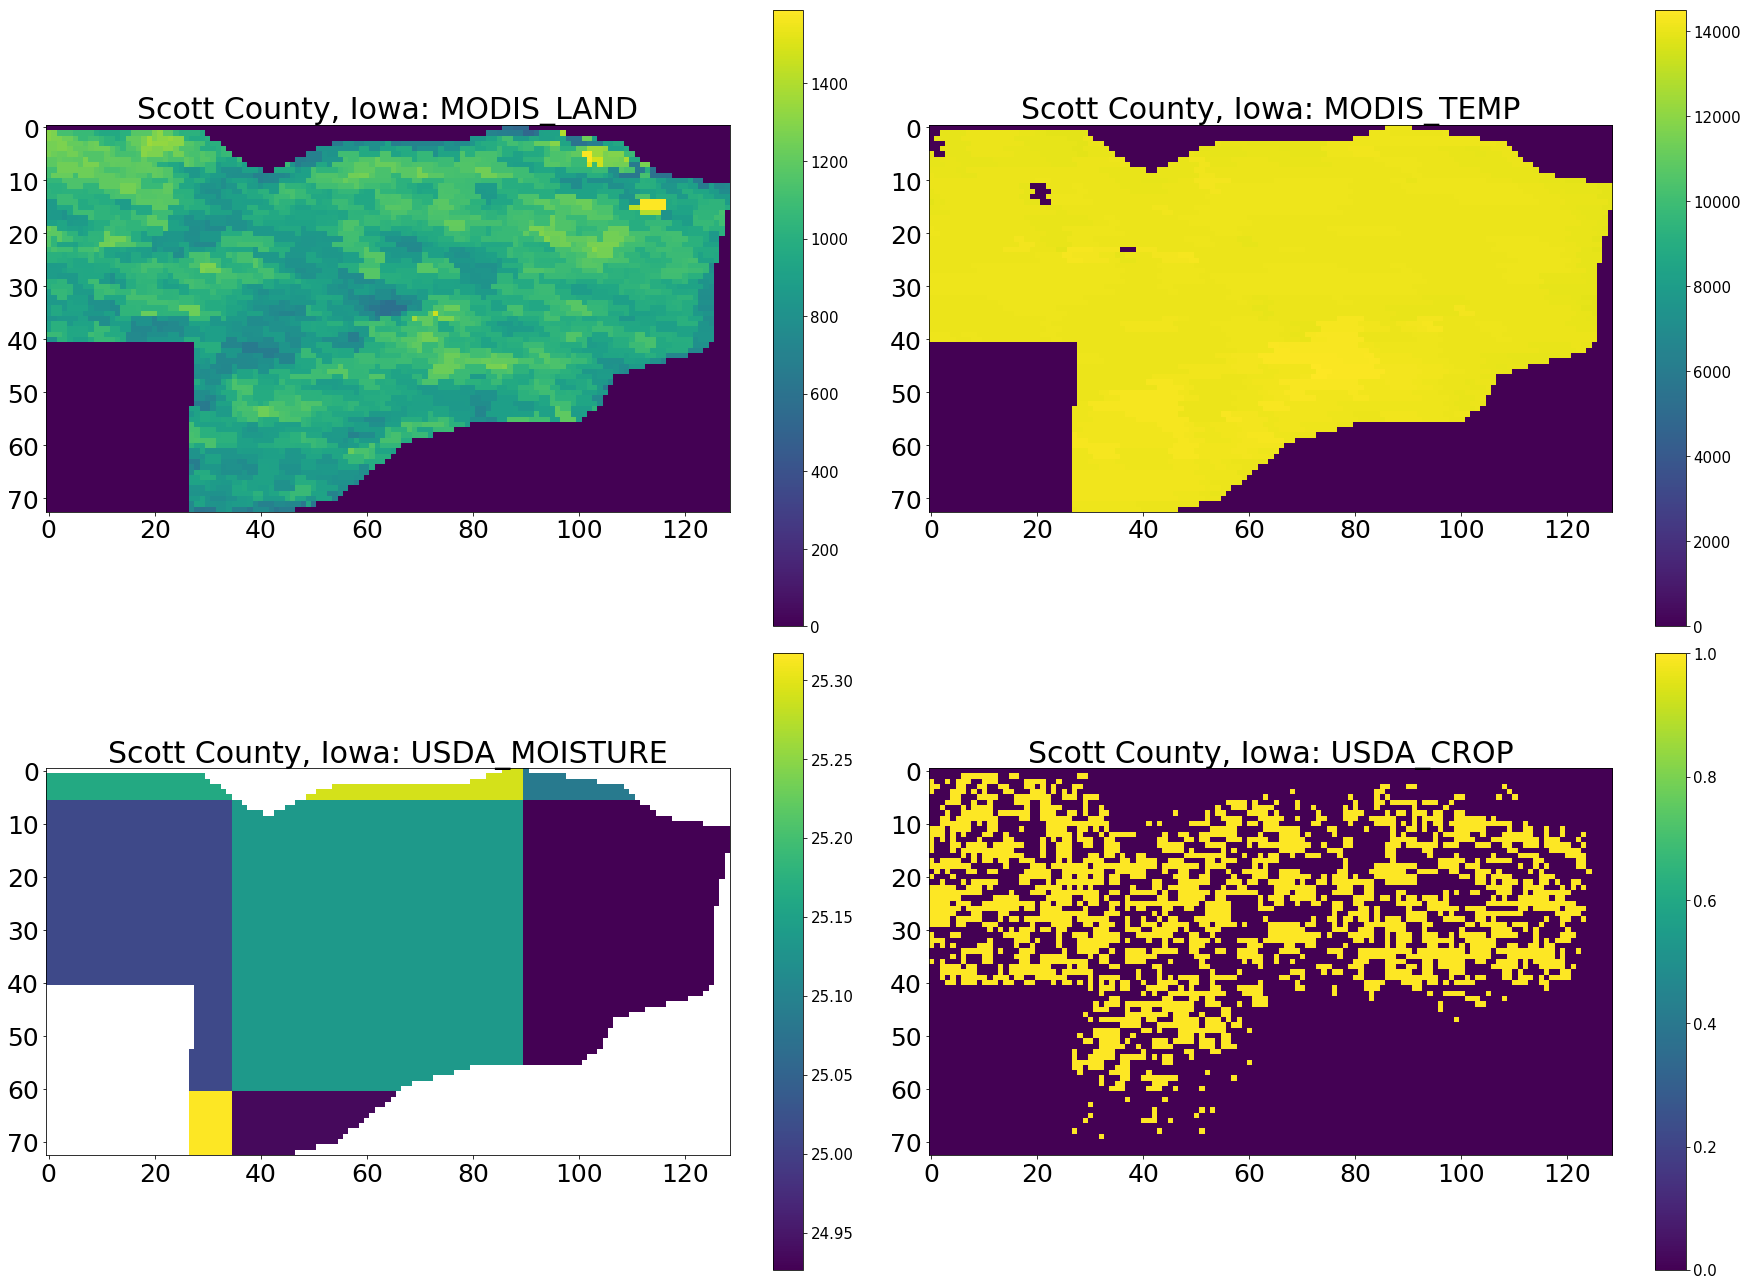

In [7]:
# Example Images

test_county = '19_163'
path = ['MODIS_LAND/MODIS_LAND_', 'MODIS_TEMP/MODIS_TEMP_', 'USDA_MOISTURE/USDA_MOISTURE_', 'USDA_CROP/USDA_CROP_']
plt.figure(figsize=(25,18))
for i, file in enumerate(path):
    test = imread('data/' + file + test_county + '.tif')
    plt.subplot(2, 2, i+1) 
    plt.imshow(test[:, :, 0])
    plt.title('Scott County, Iowa: ' + file.split('/')[1][:-1], fontsize=30)
    plt.colorbar()
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
plt.savefig('Example Images', dpi=500)
plt.tight_layout()
plt.show()

In [52]:
# Processing image (this one I didn't rerun cause it takes forever)

@nb.jit
def image_processing_I(filedata):
    path, folder, nband, fips_data, dates_of_images = filedata
    new_dates = {}
    for state, county in tqdm(fips_data):
        # Create path
        imname_mask = folder[0] + '_' + str(state) + '_' + str(county) + '.tif'
        imname_folder_1 = folder[1] + '_' + str(state) + '_' + str(county) + '.tif' 
        imname_folder_2 = folder[2] + '_' + str(state) + '_' + str(county) + '.tif'
        imname_folder_3 = folder[3] + '_' + str(state) + '_' + str(county) + '.tif'

        # Reading figures
        mask = imread(path + folder[0] + '/' + imname_mask)
        img_1 = imread(path + folder[1] + '/' + imname_folder_1)
        img_2 = imread(path + folder[2] + '/' + imname_folder_2)
        img_3 = imread(path + folder[3] + '/' + imname_folder_3)

        # Lets do just 2010-2016 first
        mask, new_dates[folder[0]] = filter_year(['2010', '2017'], mask, nband[0], dates_of_images[folder[0]])
        img_1, new_dates[folder[1]] = filter_year(['2010', '2017'], img_1, nband[1], dates_of_images[folder[1]])
        img_2, new_dates[folder[2]] = filter_year(['2010', '2017'], img_2, nband[2], dates_of_images[folder[2]])

        # Making sure the bands of the figure are correct
        if (img_1.shape[2]/nband[1] != img_2.shape[2]/nband[2]) \
        or img_1.shape[2]/nband[1] != img_3.shape[2]/nband[3]:
            print(img_1.shape[2]/nband[1], img_2.shape[2]/nband[2], img_3.shape[2]/nband[3])
            raise ValueError('Dimension of the matrix is not correct.')

        # Zero fill NaN
        img_3 = zero_fill(img_3)

        if count_img_nan(img_3) > 0:
            print('The number of NaN in MODIS_LAND, Temp, and USDA_MOISTURE and CROP are {}, {}, and {}, {}. \
            in {} state and {} county'.format(count_img_nan(img_1), count_img_nan(img_2), count_img_nan(img_3), \
                                              count_img_nan(mask), state, county))

        # Splitting images by year
        img_1_list = split_img_by_year(img_1, nband[1], new_dates[folder[1]])
        img_2_list = split_img_by_year(img_2, nband[2], new_dates[folder[2]])
        img_3_list = split_img_by_year(img_3, nband[3], new_dates[folder[1]])

        # Masking
        for i, img_year in enumerate(img_1_list):
            for j in range(img_year.shape[2]):
                img_1_list[i][:, :, j] = img_1_list[i][:, :, j] * mask[:, :, i]
        for i, img_year in enumerate(img_2_list):
            for j in range(img_year.shape[2]):
                img_2_list[i][:, :, j] = img_2_list[i][:, :, j] * mask[:, :, i]
        for i, img_year in enumerate(img_3_list):
            for j in range(img_year.shape[2]):
                img_3_list[i][:, :, j] = img_3_list[i][:, :, j] * mask[:, :, i]
        
        year_list = list(range(2010, 2017))
        # export images, this part can be improved by using HDF5
        for i, img_year in enumerate(img_1_list):
            np.save(output_path + folder[1] + '//' + str(year_list[i]) + '_' + str(state) + '_' + str(county), img_year) 
        for i, img_year in enumerate(img_2_list):
            np.save(output_path + folder[2] + '//' + str(year_list[i]) + '_' + str(state) + '_' + str(county), img_year) 
        for i, img_year in enumerate(img_3_list):
            np.save(output_path + folder[3] + '//' + str(year_list[i]) + '_' + str(state) + '_' + str(county), img_year) 
            
if __name__ == "__main__":
    path = 'data/'
    folder = ['USDA_CROP', 'MODIS_LAND', 'MODIS_TEMP', 'USDA_MOISTURE']
    nband = [1, 7, 2, 2]
    output_path = 'D://projectII_temp_data//'
    filedata = path, folder, nband, fips_data, dates_of_images
    
    image_processing_I(filedata)

100%|████████████████████████████████████| 2104/2104 [4:34:09<00:00,  7.82s/it]


100%|██████████████████████████████████████| 3000/3000 [11:58<00:00,  4.18it/s]
D:\Programs\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


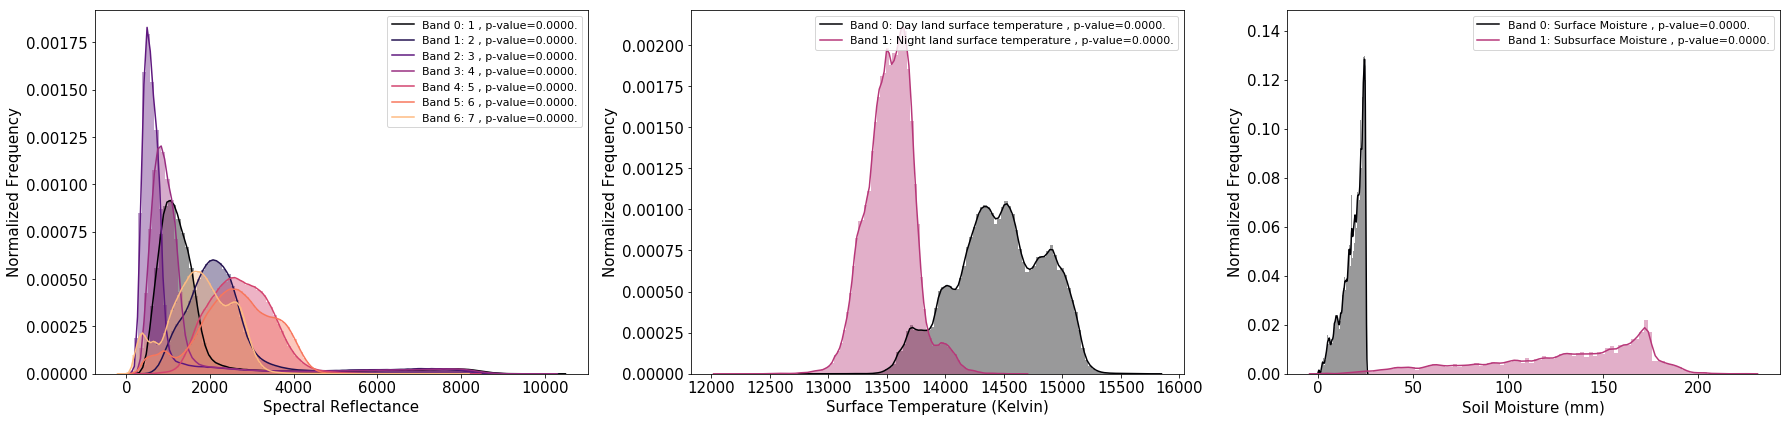

In [8]:
# Plotting distribution of band values in 3000 images

plt_MODIS_LAND = plt_img_dist('D://projectII_temp_data//MODIS_LAND//', 7, 3000, corn_grain)
plt_MODIS_TEMP = plt_img_dist('D://projectII_temp_data//MODIS_TEMP//', 2, 3000, corn_grain)
plt_USDA_MOISTURE = plt_img_dist('D://projectII_temp_data//USDA_MOISTURE//', 2, 3000, corn_grain)

cm = pylab.get_cmap('viridis')
band_name = {'MODIS_LAND': [1,2,3,4,5,6,7],
             'MODIS_TEMP': ['Day land surface temperature', 'Night land surface temperature'],
             'USDA_MOISTURE': ['Surface Moisture', 'Subsurface Moisture']}
nband = [7, 2, 2]
plt_files = [plt_MODIS_LAND, plt_MODIS_TEMP, plt_USDA_MOISTURE]
xlabel = ['Spectral Reflectance', 'Surface Temperature (Kelvin)', 'Soil Moisture (mm)']

f, axs = plt.subplots(1, 3, figsize=(25,6))

for i, (name, plt_file) in enumerate(zip(band_name, plt_files)):
    cm = pylab.get_cmap('magma')
    
    for band in range(nband[i]):
        color = cm(1.*band/nband[i])
        _, p = normaltest(plt_file[band])
        sns.distplot(plt_file[band], color=color, ax=axs[i], bins=100, \
                     kde_kws={"label": 'Band {}: {} , p-value={:.4f}.'.format(band, band_name[name][band], p)})
        
    axs[i].set_xlabel(xlabel[i], fontsize=MEDIUM_SIZE)
    axs[i].set_ylabel('Normalized Frequency', fontsize=MEDIUM_SIZE)
    
plt.tight_layout()
plt.savefig('band distribution', dpi=500)
plt.show()

In [9]:
# Getting average values of each band in a year and other stats

def get_stats(file_dir, nband, nsample, yield_dataframe):
    
    import random

    avg_MODIS_LAND = {band:[] for band in range(0, nband)}  # average per images (38 images per year for MODIS)
    std_MODIS_LAND = {band:[] for band in range(0, nband)}
    count_MODIS_LAND = {band:[] for band in range(0, nband)}
    
    avg_year = {band:[] for band in range(0, nband)}   # yearly average (for plotting)
    var_year = {band:[] for band in range(0, nband)}
    max_year = {band:[] for band in range(0, nband)}
    count_year = {band:[] for band in range(0, nband)}
    
    avg_total = {band:[] for band in range(0, nband)}     # Total average (for statistical analysis)
    std_total = {band:[] for band in range(0, nband)} 
    
    yield_ = []
    nband = nband
    nsample = nsample

    fips = yield_dataframe[['YEAR', 'STATE_FIPS', 'COUNTY_FIPS']][yield_dataframe['YEAR'] >= 2010].values
    rand_idx = random.sample(range(0, len(fips)), nsample)
    for i, _ in enumerate(fips[rand_idx]):
        try:
            test = np.load(file_dir + str(fips[i][0]) + '_' + str(fips[i][1]) + '_' + str(fips[i][2]) + '.npy')
            yield_ += [yield_dataframe['YIELD'][(yield_dataframe['STATE_FIPS'] == int(fips[i][1])) & (yield_dataframe['COUNTY_FIPS'] == int(fips[i][2])) \
                                          & (yield_dataframe['YEAR'] == int(fips[i][0]))].values]
            for band in range(nband):
                bands = list(np.arange(band, test.shape[2], nband)) 
                non_zero_index = test[:, :, bands].nonzero()
                count_year[band] += [len(non_zero_index[0])]
                avg_year[band] += [test[:, :, bands][non_zero_index].mean()]
                var_year[band] += [test[:, :, bands][non_zero_index].var()]
                max_year[band] += [test[:, :, bands].max()]

        except:
            pass

    for band in range(nband):
        # Delete NaN (i.e. samples that do not have any corn in that year)
        nan_idx = np.argwhere(np.isnan(avg_year[band]))
        avg_year[band] = np.delete(avg_year[band], nan_idx)
        var_year[band] = np.delete(var_year[band], nan_idx)
        count_year[band] = np.delete(count_year[band], nan_idx)
        

        avg_total[band] = np.sum(avg_year[band]*np.array(count_year[band]))/ np.sum(count_year[band])
        std_total[band] = np.sqrt(np.sum(var_year[band]*np.array(count_year[band]))/ np.sum(count_year[band]))
        
    yield_ = np.delete(yield_, nan_idx)       
    return avg_year, count_year, max_year, yield_, avg_total, std_total


nsample = 2000

avg_year_LAND, count_year_LAND, max_year_LAND, yield_LAND, avg_total_LAND, std_total_LAND = \
get_stats('D://projectII_temp_data//MODIS_LAND//', 7, nsample, corn_grain)

avg_year_TEMP, count_year_TEMP, max_year_TEMP, yield_TEMP, avg_total_TEMP, std_total_TEMP =\
get_stats('D://projectII_temp_data//MODIS_TEMP//', 2, nsample, corn_grain)

avg_year_MOISTURE, count_year_MOISTURE, max_year_MOISTURE, yield_MOISTURE, avg_total_MOISTURE, std_total_MOISTURE =\
get_stats('D://projectII_temp_data//USDA_MOISTURE//', 2, nsample, corn_grain)

D:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice.
D:\Programs\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: Degrees of freedom <= 0 for slice
D:\Programs\Anaconda3\lib\site-packages\numpy\core\_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
D:\Programs\Anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
D:\Programs\Anaconda3\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
D:\Programs\Anaconda3\lib\site-packages\numpy\core\_methods.py:127: RuntimeWarning: invalid value encou

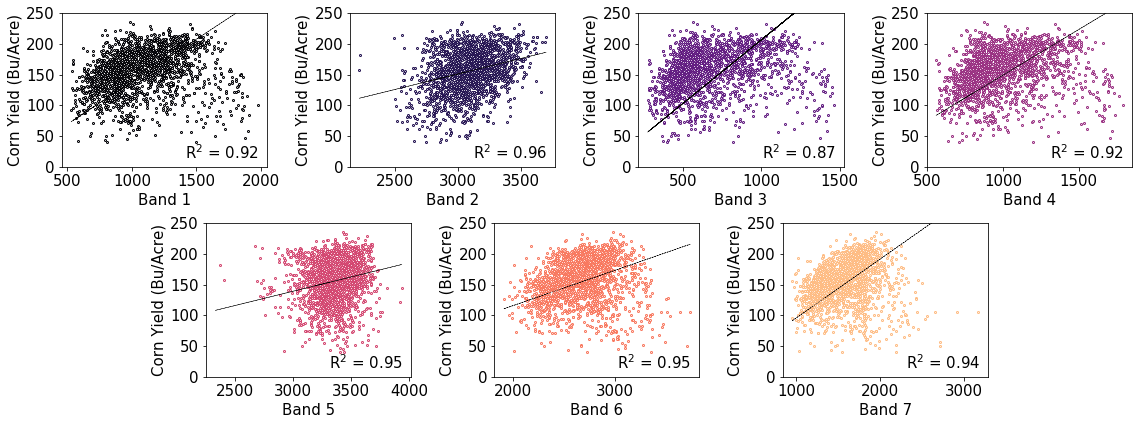

In [10]:
# Plotting correlations

fig = plt.figure(figsize=(16, 6))
gs = gridspec.GridSpec(nrows=2, ncols=16)

ax11 = fig.add_subplot(gs[0, :4])
ax21 = fig.add_subplot(gs[0, 4:8])
ax31 = fig.add_subplot(gs[0, 8:12])
ax41 = fig.add_subplot(gs[0, 12:16])
ax12 = fig.add_subplot(gs[1, 2:6])
ax22 = fig.add_subplot(gs[1, 6:10])
ax32 = fig.add_subplot(gs[1, 10:14])

axs = [ax11, ax21, ax31, ax41, ax12, ax22, ax32]
cm = pylab.get_cmap('magma')
nband = 7

for ax, band in zip(axs, avg_year_LAND):
    
    x = np.array(avg_year_LAND[band])
    y = np.array(yield_LAND)
    
    color = cm(1*band/nband)
    ax.scatter(x, y, color='white', edgecolors=color, s=4)
    ax.set_xlabel('Band ' + str(band + 1))
    ax.set_ylabel('Corn Yield (Bu/Acre)')
    
    # Generated linear fit
    results = sm.OLS(y, x).fit()
    line = results.params[0]*x
    ax.plot(x, line, '--', color='black',  linewidth=0.5)
    ax.annotate('R$^2$ = {:.2f}'.format(results.rsquared), xy=(0.6, 0.05), xycoords='axes fraction', fontsize=15)
    ax.set_ylim([0, 250])

fig.tight_layout()
plt.savefig('MODIS', dpi=500)
plt.show()

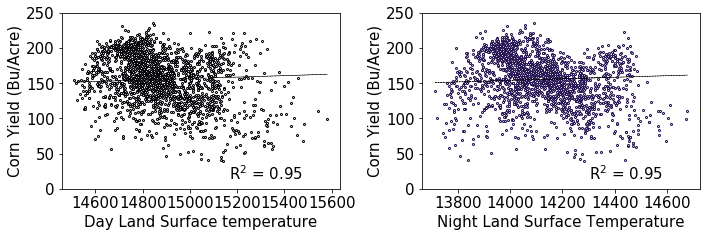

In [11]:
# Plotting correlations

fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(nrows=2, ncols=16)

ax11 = fig.add_subplot(gs[0, :8])
ax21 = fig.add_subplot(gs[0, 8:16])
xlabel = ['Day Land Surface temperature', 'Night Land Surface Temperature']
axs = [ax11, ax21]
cm = pylab.get_cmap('magma')
nband = 7

for i, (ax, band) in enumerate(zip(axs, avg_year_TEMP)):
    
    x = np.array(avg_year_TEMP[band])
    y = np.array(yield_TEMP)
    # Delete NaN
    nan_idx = np.argwhere(np.isnan(x))
    x = np.delete(x, nan_idx)
    y = np.delete(y, nan_idx)
    
    color = cm(1*band/nband)
    ax.scatter(x, y, color='white', edgecolors=color, s=4)
    ax.set_xlabel(xlabel[i])
    ax.set_ylabel('Corn Yield (Bu/Acre)')
    
    # Generated linear fit
    results = sm.OLS(y, x).fit()
    line = results.params[0]*x
    ax.plot(x, line, '--', color='black',  linewidth=0.5)
    ax.annotate('R$^2$ = {:.2f}'.format(results.rsquared), xy=(0.6, 0.05), xycoords='axes fraction', fontsize=15)
    ax.set_ylim([0, 250])

fig.tight_layout()
plt.savefig('Temperature', dpi=500)
plt.show()

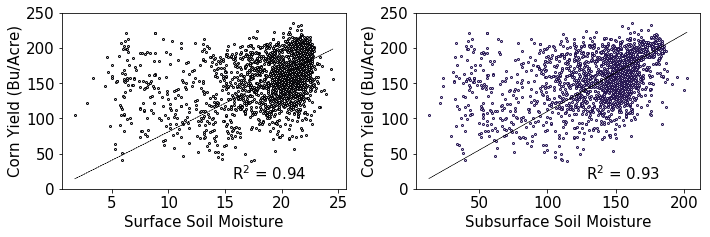

In [12]:
# Plotting correlations

fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(nrows=2, ncols=16)

ax11 = fig.add_subplot(gs[0, :8])
ax21 = fig.add_subplot(gs[0, 8:16])
xlabel = ['Surface Soil Moisture', 'Subsurface Soil Moisture']
axs = [ax11, ax21]
cm = pylab.get_cmap('magma')
nband = 7

for i, (ax, band) in enumerate(zip(axs, avg_year_MOISTURE)):
    
    x = np.array(avg_year_MOISTURE[band])
    y = np.array(yield_MOISTURE)
    # Delete NaN
    nan_idx = np.argwhere(np.isnan(x))
    x = np.delete(x, nan_idx)
    y = np.delete(y, nan_idx)
    
    color = cm(1*band/nband)
    ax.scatter(x, y, color='white', edgecolors=color, s=4)
    ax.set_xlabel(xlabel[i])
    ax.set_ylabel('Corn Yield (Bu/Acre)')
    
    # Generated linear fit
    results = sm.OLS(y, x).fit()
    line = results.params[0]*x
    ax.plot(x, line, '--', color='black',  linewidth=0.5)
    ax.annotate('R$^2$ = {:.2f}'.format(results.rsquared), xy=(0.6, 0.05), xycoords='axes fraction', fontsize=15)
    ax.set_ylim([0, 250])

fig.tight_layout()
plt.savefig('MOISTURE', dpi=500)
plt.show()

In [817]:
# Binning images (this one I didn't rerun cause it takes forever)

def create_input_3D(input_dir, fips, output_dir):
    
    from tqdm import tqdm
    resolution = 128
    for fip in tqdm(fips):
        year = fip[0]
        state = fip[1]
        county = fip[2]

        img_1 = np.load(input_dir[0] + str(year) +'_' + str(state) + '_' + str(county) + '.npy')
        img_2 = np.load(input_dir[1] + str(year) +'_' + str(state) + '_' + str(county) + '.npy')
        img_3 = np.load(input_dir[2] + str(year) +'_' + str(state) + '_' + str(county) + '.npy')

        bin_MODIS_LAND = get_bin(img_1, [[0, 4000]]*4 + [[0, 5000]]*2 + [[0, 4000]], 7, resolution)
        bin_MODIS_TEMP = get_bin(img_2, [[13500, 15250], [13000, 14250]], 2, resolution)
        bin_USDA_MOISTURE = get_bin(img_3, [[0, 26], [0, 200]], 2, resolution)

        bin_all = np.concatenate([bin_MODIS_LAND, bin_MODIS_TEMP, bin_USDA_MOISTURE], axis=0)

        np.save(output_dir + '//' + str(year) + '_' + str(state) + '_' + str(county), bin_all)

if __name__ == "__main__":
    
    fips = corn_grain[['YEAR', 'STATE_FIPS', 'COUNTY_FIPS']][corn_grain['YEAR'] >= 2010]
    fips = fips[((fips['STATE_FIPS'] != 51) | (fips['COUNTY_FIPS'] != 131)) & \
               ((fips['STATE_FIPS'] != 46) | (fips['COUNTY_FIPS'] != 102))]
    fips = fips[['YEAR', 'STATE_FIPS', 'COUNTY_FIPS']].values
    
    fips.to_csv('data/processed_fips.csv')
    
    create_input_3D(['D://projectII_temp_data//MODIS_LAND//', 
                    'D://projectII_temp_data//MODIS_TEMP//', 
                    'D://projectII_temp_data//USDA_MOISTURE//'], 
                    fips, \
                    'data//PROCESSED')

  0%|▏                                      | 49/11077 [00:11<41:36,  4.42it/s]D:\Programs\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
100%|██████████████████████████████████| 11077/11077 [3:24:56<00:00,  1.11s/it]


In [13]:
# Originally we output the processed input as (nband, resolution, frame per year) per file (11077) files
# I just realized that previous shaping was wrong and here we are reshaping it to (frames, 1, resolution, nband)

nband = 11
resolution = 128

for file_name in tqdm(glob.glob('data\PROCESSED/*.npy')):
    year, state, county = file_name[15:-4].split('_')
    processed_img = np.load(file_name)
    output_name = ('_').join([year, state, county])
    
    frames = processed_img.shape[2]
    new_processed_img = np.zeros((frames, 1, resolution, nband))
    for frame in range(frames):
        for band in range(nband):
            new_processed_img[frame, :, :, band] = processed_img[band, :, frame]
    np.save('data/PROCESSED_II/' + output_name + '.npy', new_processed_img)

100%|████████████████████████████████████| 11077/11077 [03:48<00:00, 48.43it/s]


In [14]:
# The previous preprocessing we forgot that the mask from satellites can cause some images become all zeros
# although the USDA data says it has yields. This discrepancy cause the image to be nan during the binning process.

count_nonnan = 0
removed_ID = []
for filename in tqdm(glob.glob('data/PROCESSED_II/*.npy')):
    file = np.load(filename)
    if np.sum(np.isnan(file)) == 0:
        np.save('data/PROCESSED_III/' + filename[18:-4] + '.npy', file)
        count_nonnan += 1
    else:
        removed_ID += [filename[18:-4]]
print('The number of processed files with no nan is {} from the original of {}.'.format(count_nonnan, len(glob.glob('data/PROCESSED_II/*.npy'))))
#pickle.dump(removed_ID, open("data/removed_ID.p", "wb" ) )

100%|████████████████████████████████████| 11077/11077 [21:58<00:00,  8.40it/s]


The number of processed files with no nan is 9062 from the original of 11077.


In [15]:
# Preparing {county_year:yield} dictionary data for model evaluation

# Load fips and other data
fips = pd.DataFrame(pd.read_csv('data/processed_fips.csv').drop(['Unnamed: 0'], axis=1))
corn_grain = pd.read_csv('data/corn_grain.csv').drop(['Unnamed: 0'], axis=1)
fips_yields = corn_grain.merge(fips)[['YEAR', 'STATE_FIPS', 'COUNTY_FIPS', 'YIELD']].astype(str)
fips_yields['YIELD'] = fips_yields['YIELD'].astype(float)
fips_yields['ID'] = fips_yields.apply(lambda row: row['YEAR'] + '_' + row['STATE_FIPS'] + \
                                      '_' + row['COUNTY_FIPS'], axis=1)
# Remove the IDs with Nans
removed_ID = pd.DataFrame(removed_ID, columns=['ID'])
fips_yields = fips_yields[~fips_yields['ID'].isin([i[0] for i in removed_ID.values.tolist()])]

fips_yields = fips_yields.set_index('ID')
display(fips_yields.head())

print('\n' + '#'*13, 'YIELD MAPPING', '#'*13)

yields_train = fips_yields[['YIELD']][fips_yields['YEAR'] != '2016'].to_dict()['YIELD'] # data from year 2010-2015
yields_test = fips_yields[['YIELD']][fips_yields['YEAR'] == '2016'].to_dict()['YIELD'] # data form year 2016

keys = ['train', 'validation']
values = [yields_train, yields_test]
yields = {key:value for key, value in zip(keys, values)}

for key in list(yields['train'].keys())[0:5]:
    print(key, '=',  yields['train'][key])
print('#'*41)
#pickle.dump(yields, open("data/yields.p", "wb" ) )

,YEAR,STATE_FIPS,COUNTY_FIPS,YIELD
ID,,,,
2016_1_47,2016,1,47,118.8
2016_1_51,2016,1,51,151.8
2016_1_87,2016,1,87,131.9
2016_1_91,2016,1,91,137.2
2016_1_105,2016,1,105,123.7



############# YIELD MAPPING #############
2015_1_51 = 197.6
2015_1_105 = 127.7
2015_1_3 = 147.2
2015_1_35 = 54.3
2015_1_53 = 124.6
#########################################
